### Import libraries

In [30]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, confusion_matrix

### Import data

In [31]:
filename = 'C:\\Users\\KevinCepeda\\Downloads\\pp01_t16.csv'
Types = [1,2,3,4,5,6,7,8,9,10,11,12]
mod = ['Air','Air','Air','Air','Vib','Vib','Vib','Vib','Car','Car','Car','Car']

In [52]:
df = pd.read_csv(filename)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'AFz', 'CPz', 'POz']
patterns = ['_d1', '_d2', '_d3', '_d4', '_d5', '_a1']
column_names = ['channels', 'ID', 'Class', 'Epoch'] + [f'{ch}{pt}' for ch in channels for pt in patterns]

if len(column_names) != len(df.columns):
    raise ValueError(f"Number of column names ({len(column_names)}) does not match number of columns in DataFrame ({len(df.columns)})")

df.columns = column_names

df = df[df['Class'].isin(Types)]

class_mapping = dict(zip(Types, mod))
df['Class'] = df['Class'].map(class_mapping)
df = df.drop(columns=['channels', 'ID', 'Epoch'])

data_array = df.drop(['Class'], axis=1).values
class_labels = df['Class'].values


In [53]:
data_array = df.drop(['Class'], axis=1).values
class_labels = df['Class'].values
X_train, X_test, y_train, y_test = train_test_split(data_array, class_labels, test_size=0.2, random_state=42)

### Train models

In [34]:
def RForest_train(X_train, y_train, X_test, y_test, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', validation='standard', cv=5, echo=True):
        rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                          max_features=max_features, random_state=42)
        
        if validation == 'standard':
            rf_model.fit(X_train, y_train)
            y_pred = rf_model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            if echo:
                print(f"------------------------------------------------------------")
                print(f"Accuracy of Random Forest: {accuracy * 100:.2f}%")
                print(f"------------------------------------------------------------")
            return {'accuracy': accuracy * 100}
        elif validation == 'kfold':
            scores = cross_validate(rf_model, np.vstack((X_train, X_test)), np.concatenate((y_train, y_test)), cv=cv, scoring='accuracy', return_train_score=True)
            mean_test_accuracy = np.mean(scores['test_score']) * 100
            std_test_accuracy = np.std(scores['test_score']) * 100
            if echo:
                print(f"------------------------------------------------------------")
                print(f"Average K-Fold Test Accuracy of RForest: {np.mean(scores['test_score']) * 100:.2f}%")
                print(f"Average K-Fold Train Accuracy of RForest: {np.mean(scores['train_score']) * 100:.2f}%")
                print(f"Std Dev of K-Fold Test Accuracy of RForest: {np.std(scores['test_score']) * 100:.2f}%")
                print(f"Std Dev of K-Fold Train Accuracy of RForest: {np.std(scores['train_score']) * 100:.2f}%")
                print(f"------------------------------------------------------------")
            return {'mean_accuracy': mean_test_accuracy, 'std_accuracy': std_test_accuracy}
    
def KNN_train(X_train, y_train, X_test, y_test, hot_encode = False, n_neighbors=20, p=1, weights='distance', leaf_size=20, algorithm='auto', validation='standard', cv=5, echo = True):
        knn_model = KNeighborsClassifier(n_neighbors=n_neighbors, p=p, weights=weights, leaf_size=leaf_size, algorithm=algorithm)

        if validation == 'standard':
            knn_model.fit(X_train, y_train)
            y_pred = knn_model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            if echo:
                print(f"------------------------------------------------------------")
                print(f"Accuracy of KNN: {accuracy * 100:.2f}%")
                print(f"------------------------------------------------------------")
            return {'accuracy': accuracy * 100}
        elif validation == 'kfold':
            scores = cross_validate(knn_model, np.vstack((X_train, X_test)), np.concatenate((y_train, y_test)), cv=cv, scoring='accuracy', return_train_score=True)
            mean_test_accuracy = np.mean(scores['test_score']) * 100
            std_test_accuracy = np.std(scores['test_score']) * 100
            if echo:
                print(f"------------------------------------------------------------")
                print(f"Average K-Fold Test Accuracy of KNN: {np.mean(scores['test_score']) * 100:.2f}%")
                print(f"Average K-Fold Train Accuracy of KNN: {np.mean(scores['train_score']) * 100:.2f}%")
                print(f"Std Dev of K-Fold Test Accuracy of KNN: {np.std(scores['test_score']) * 100:.2f}%")
                print(f"Std Dev of K-Fold Train Accuracy of KNN: {np.std(scores['train_score']) * 100:.2f}%")
                print(f"------------------------------------------------------------")
            return {'mean_accuracy': mean_test_accuracy, 'std_accuracy': std_test_accuracy}
        else:
            print("Invalid validation method specified.")         

def MLP_train(X_train, y_train, X_test, y_test, hot_encode = False, hidden_layer_sizes=(100,), activation='relu', solver='adam', validation='standard', alpha=0.001, cv=5, max_iter = 200, echo = True):
    mlp_model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, alpha=0.001, batch_size='auto', learning_rate='constant', 
                                learning_rate_init=0.001, power_t=0.5, max_iter=max_iter, shuffle=True, random_state=None, tol=0.0001, verbose=False, 
                                warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, 
                                beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)

    if hot_encode:
        # Initialize the OneHotEncoder
        encoder = OneHotEncoder(sparse=False, categories='auto')
        # Fit and transform y_train and y_test
        y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
        y_test_encoded = encoder.transform(y_test.reshape(-1, 1))
    else:
        # No encoding, use the original target variables
        y_train_encoded = y_train
        y_test_encoded = y_test        
    
    
    if validation == 'standard':
        mlp_model.fit(X_train, y_train_encoded)
        y_pred = mlp_model.predict(X_test)
        accuracy = accuracy_score(y_test_encoded, y_pred)
        if echo:
            print(f"------------------------------------------------------------")
            print(f"Accuracy of MLP: {accuracy * 100:.2f}%")
            print(f"------------------------------------------------------------")
        return {'accuracy': accuracy * 100}
    elif validation == 'kfold':
        scores = cross_validate(mlp_model, np.vstack((X_train, X_test)), np.concatenate((y_train_encoded, y_test_encoded)), cv=cv, scoring='accuracy', return_train_score=True)
        mean_test_accuracy = np.mean(scores['test_score']) * 100
        std_test_accuracy = np.std(scores['test_score']) * 100
        if echo:
            print(f"------------------------------------------------------------")
            print(f"Average K-Fold Test Accuracy of MLP: {np.mean(scores['test_score']) * 100:.2f}%")
            print(f"Average K-Fold Train Accuracy of MLP: {np.mean(scores['train_score']) * 100:.2f}%")
            print(f"Std Dev of K-Fold Test Accuracy of MLP: {np.std(scores['test_score']) * 100:.2f}%")
            print(f"Std Dev of K-Fold Train Accuracy of MLP: {np.std(scores['train_score']) * 100:.2f}%")
            print(f"------------------------------------------------------------")
        return {'mean_accuracy': mean_test_accuracy, 'std_accuracy': std_test_accuracy}
    else:
        print("Invalid validation method specified.")

KNN_train(X_train, y_train, X_test, y_test,validation='kfold', cv = 5)
RForest_train(X_train, y_train, X_test, y_test,validation='kfold', cv = 5)
MLP_train(X_train, y_train, X_test, y_test,hidden_layer_sizes=(200, 100, 50), max_iter=10000, alpha=0.001, validation='kfold', cv=5)

------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 56.58%
Average K-Fold Train Accuracy of KNN: 100.00%
Std Dev of K-Fold Test Accuracy of KNN: 1.21%
Std Dev of K-Fold Train Accuracy of KNN: 0.00%
------------------------------------------------------------
------------------------------------------------------------
Average K-Fold Test Accuracy of RForest: 71.25%
Average K-Fold Train Accuracy of RForest: 100.00%
Std Dev of K-Fold Test Accuracy of RForest: 1.15%
Std Dev of K-Fold Train Accuracy of RForest: 0.00%
------------------------------------------------------------
------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 64.49%
Average K-Fold Train Accuracy of MLP: 95.15%
Std Dev of K-Fold Test Accuracy of MLP: 1.41%
Std Dev of K-Fold Train Accuracy of MLP: 3.32%
------------------------------------------------------------


{'mean_accuracy': 64.48950447425818, 'std_accuracy': 1.406986116782282}

### Feature Selection

Selecting features based on mutual information
Number of features selected: 92


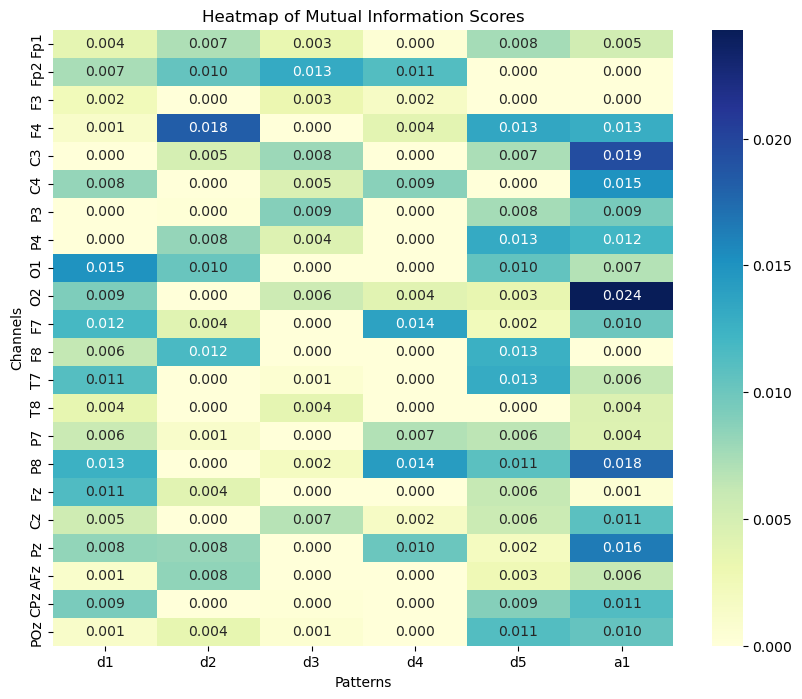

In [39]:
import seaborn as sns
plot = True
number_of_f=0 
echo = False
threshold=0.0005

print("Selecting features based on mutual information")
mutual_info_scores = mutual_info_classif(np.vstack((X_train, X_test)), np.concatenate((y_train, y_test)))

if number_of_f > 0:
    sorted_indices = np.argsort(mutual_info_scores)[::-1]
    selected_features = sorted_indices[:number_of_f]
else:
    selected_features = np.where(mutual_info_scores > threshold)[0]

channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'AFz', 'CPz', 'POz']
patterns = ['d1', 'd2', 'd3', 'd4', 'd5', 'a1']
feature_names = [f'{ch}_{pt}' for ch in channels for pt in patterns]

if echo:
    for feature, score in zip(feature_names, mutual_info_scores):
        print(f"{feature}: Mutual Information Score: {score:.5f}")

X_train_sf = X_train[:, selected_features]
X_test_sf = X_test[:, selected_features]

if plot:
    print(f"Number of features selected: {len(selected_features)}")
    scores_matrix = mutual_info_scores.reshape(len(channels), len(patterns))
    scores_df = pd.DataFrame(scores_matrix, index=channels, columns=patterns)
    plt.figure(figsize=(10, 8))
    sns.heatmap(scores_df, annot=True, fmt=".3f", cmap="YlGnBu")
    plt.title('Heatmap of Mutual Information Scores')
    plt.xlabel('Patterns')
    plt.ylabel('Channels')
    plt.show()

Selecting features based on mutual information
Number of features selected: 92


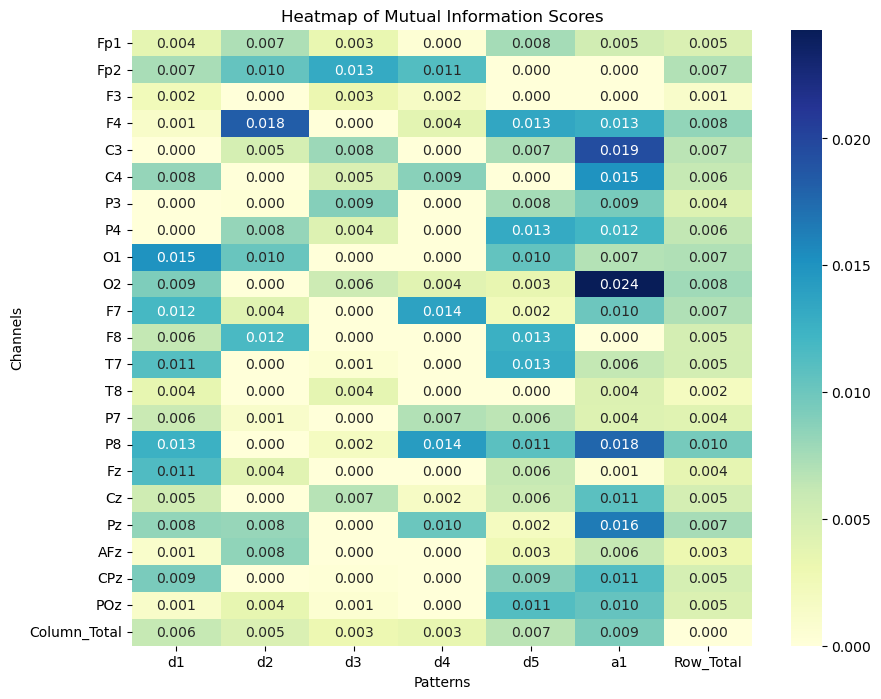

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

plot = True
number_of_f = 0 
echo = False
threshold = 0.0005

print("Selecting features based on mutual information")
mutual_info_scores = mutual_info_classif(np.vstack((X_train, X_test)), np.concatenate((y_train, y_test)))

if number_of_f > 0:
    sorted_indices = np.argsort(mutual_info_scores)[::-1]
    selected_features = sorted_indices[:number_of_f]
else:
    selected_features = np.where(mutual_info_scores > threshold)[0]

channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'AFz', 'CPz', 'POz']
patterns = ['d1', 'd2', 'd3', 'd4', 'd5', 'a1']
feature_names = [f'{ch}_{pt}' for ch in channels for pt in patterns]

if echo:
    for feature, score in zip(feature_names, mutual_info_scores):
        print(f"{feature}: Mutual Information Score: {score:.5f}")

X_train_sf = X_train[:, selected_features]
X_test_sf = X_test[:, selected_features]

if plot:
    print(f"Number of features selected: {len(selected_features)}")
    scores_matrix = mutual_info_scores.reshape(len(channels), len(patterns))
    scores_df = pd.DataFrame(scores_matrix, index=channels, columns=patterns)
    
    # Add total row and column sums
    scores_df['Row_Total'] = scores_df.sum(axis=1)/6
    scores_df.loc['Column_Total'] = scores_df.sum(axis=0)/22

    scores_df['Row_Total'].iloc[-1] =0
    plt.figure(figsize=(10, 8))
    sns.heatmap(scores_df, annot=True, fmt=".3f", cmap="YlGnBu")
    plt.title('Heatmap of Mutual Information Scores')
    plt.xlabel('Patterns')
    plt.ylabel('Channels')
    plt.show()


[[-5.82354159e-17  9.51056516e-01]
 [ 5.82354159e-17  9.51056516e-01]
 [-3.88572981e-01  6.73028145e-01]
 [ 3.88572981e-01  6.73028145e-01]
 [ 0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [-3.88572981e-01  6.73028145e-01]
 [ 3.88572981e-01  6.73028145e-01]
 [ 5.82354159e-17 -9.51056516e-01]
 [-5.82354159e-17 -9.51056516e-01]
 [-3.59914664e-17  5.87785252e-01]
 [ 3.59914664e-17  5.87785252e-01]
 [ 0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 3.59914664e-17 -5.87785252e-01]
 [-3.59914664e-17 -5.87785252e-01]
 [ 7.07106781e-01  7.07106781e-01]
 [ 0.00000000e+00  0.00000000e+00]
 [-7.07106781e-01 -7.07106781e-01]
 [ 3.90731128e-01  9.20504853e-01]
 [-9.27183855e-01 -3.74606593e-01]
 [-3.90731128e-01 -9.20504853e-01]]


d:\Miniconda\envs\ML\lib\site-packages\mne\viz\topomap.py:717: RuntimeWarning: invalid value encountered in divide
  slopes = diffs[:, 1] / diffs[:, 0]


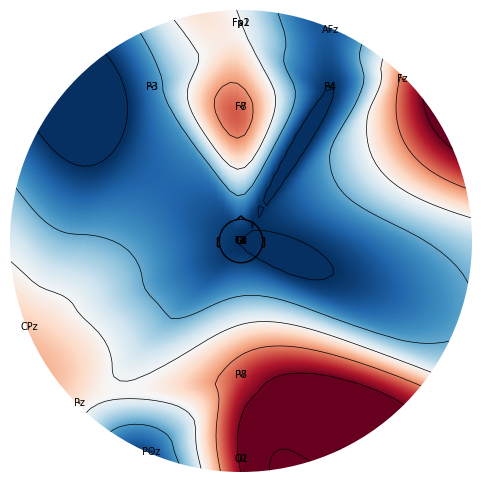

d:\Miniconda\envs\ML\lib\site-packages\mne\viz\topomap.py:717: RuntimeWarning: invalid value encountered in divide
  slopes = diffs[:, 1] / diffs[:, 0]


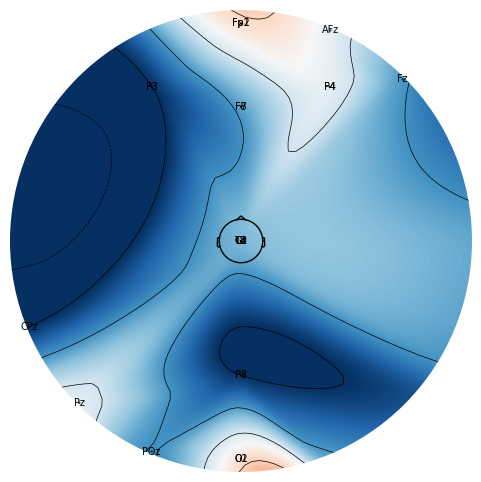

d:\Miniconda\envs\ML\lib\site-packages\mne\viz\topomap.py:717: RuntimeWarning: invalid value encountered in divide
  slopes = diffs[:, 1] / diffs[:, 0]


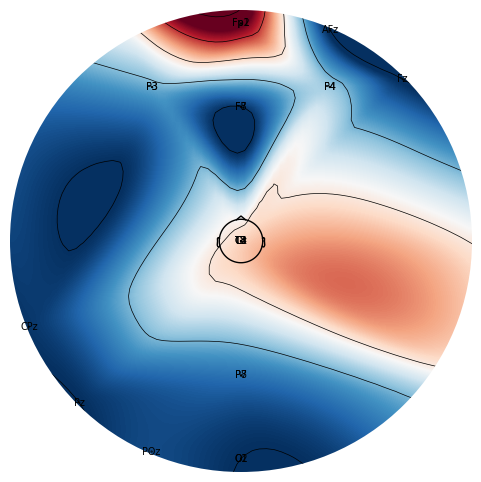

d:\Miniconda\envs\ML\lib\site-packages\mne\viz\topomap.py:717: RuntimeWarning: invalid value encountered in divide
  slopes = diffs[:, 1] / diffs[:, 0]


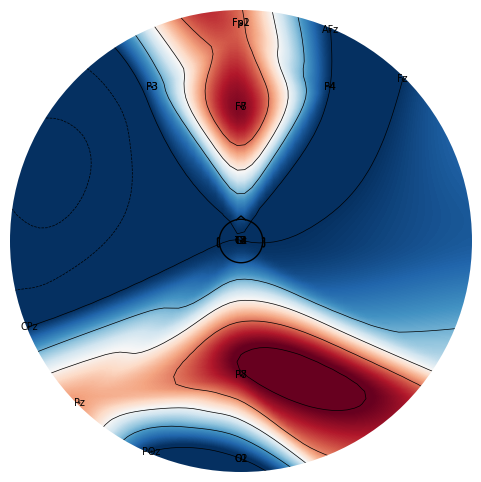

d:\Miniconda\envs\ML\lib\site-packages\mne\viz\topomap.py:717: RuntimeWarning: invalid value encountered in divide
  slopes = diffs[:, 1] / diffs[:, 0]


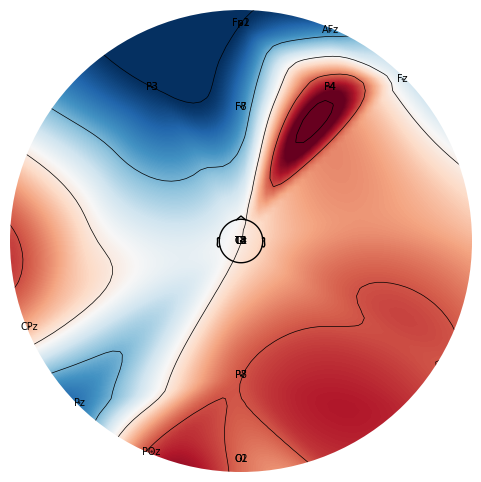

d:\Miniconda\envs\ML\lib\site-packages\mne\viz\topomap.py:717: RuntimeWarning: invalid value encountered in divide
  slopes = diffs[:, 1] / diffs[:, 0]


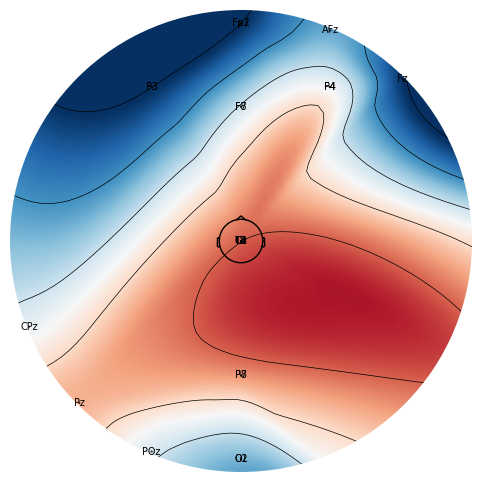

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mne import create_info
from mne.viz import plot_topomap

# Load theta and phi values from the provided image
theta_phi_data = {
    'Name': ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'AFz', 'CPz', 'POz'],
    'Theta': [-90, 90, -60, 60, -45, 45, -60, 60, -90, 90, -90, 90, -90, 90, -90, 90, 45, 0, 45, 67, 22, 67],
    'Phi': [-72, 72, -51, 51, 0, 0, -51, 51, 72, -72, -36, 36, 0, 0, 36, -36, 90, 0, -90, 90, -90, -90]
}
theta_phi_df = pd.DataFrame(theta_phi_data)

# Convert theta and phi to Cartesian coordinates
def spherical_to_cartesian(theta, phi):
    theta = np.radians(theta)
    phi = np.radians(phi)
    x = np.cos(theta) * np.sin(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(phi)
    return x,y

# Create positions array
pos = np.array([spherical_to_cartesian(row['Theta'], row['Phi']) for idx, row in theta_phi_df.iterrows()])
print(pos)

# Create info structure
info = create_info(theta_phi_data['Name'], sfreq=250, ch_types='eeg')
# Create topoplots for each pattern
for i, pattern in enumerate(patterns):
    data = scores_matrix[:, i]
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    plot_topomap(data, pos, axes=ax, names=channels,  cmap='RdBu_r')
    ax.set_title(f'Topoplot for {pattern}')
    plt.show()